Unique Camera Callibration For Camera-Lidar Sensor Fusion

Goal

To unwarp the picture so that the camera matches up with the lidar points

![title](general_images/image_lidar_overlay.png)

![title](general_images/lidar_points.png)

Problem

Standard methods of image calibration (for example https://wiki.ros.org/image_proc) do not work well with our camera (https://reolink.com/us/product/reolink-duo-poe/)

![title](general_images/camera.jpg)

Import necessary libraries

In [253]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [254]:
middle_offset_1 = 175
middle_offset_2 = -300
middle_image = cv2.imread('calibration_images/middle_image.png')
right_offset = middle_image.shape[1] // 2
middle_image = middle_image[:, middle_offset_1:middle_offset_2]
left_image = cv2.imread('calibration_images/left_image.png')[:, :right_offset]
right_image = cv2.imread('calibration_images/right_image.png')[:, right_offset:]

Defines function to display image

In [255]:
def display(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [256]:
def getCorners(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(
        gray_image, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    
    return corners

Defines function to display corners

In [257]:
def displayCorners(image, corners, display_numbers=True):
    _image = image.copy()
    red = (0, 0, 255)
    for i in range(len(corners)):
        point = corners[i, 0].astype(int)
        cv2.circle(_image, point, 3, red, -1)
        if display_numbers:
            cv2.putText(_image, str(i), point - [0, 2], 0, 0.5, red)
    display(_image)

Display left camera picture of calibration board

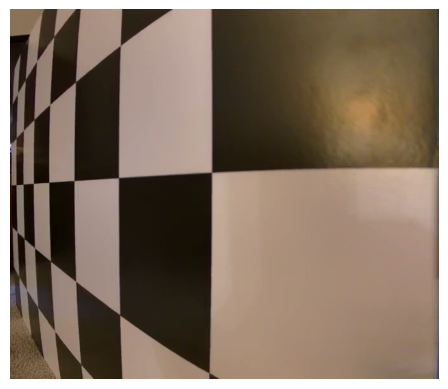

In [260]:
display(left_image)

Find potential corners

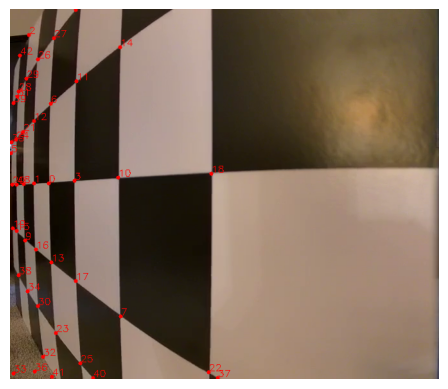

In [261]:
corners = getCorners(left_image)
displayCorners(left_image, corners)

Manually remove incorrect corners

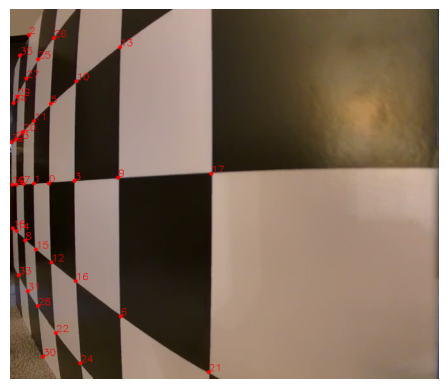

In [262]:
def remove_corners(corners, indexes_to_remove):
    mask = [True] * len(corners)
    for i in indexes_to_remove:
        mask[i] = False
    real_corners = corners[mask]
    return real_corners

removed_corners = remove_corners(corners, [37, 33, 36, 40, 5, 28, 41, 43])
displayCorners(left_image, removed_corners)

Lineup the indexes of the corners

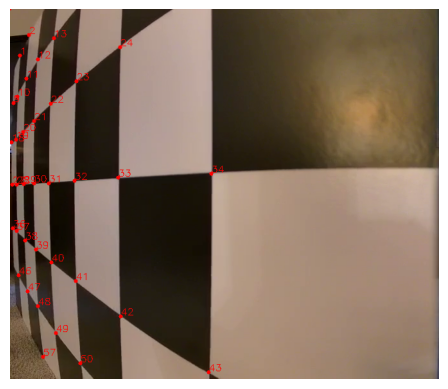

In [263]:
def relabel_corner_indexes(corners, relabling, grid_size):
    assert (sorted(list(relabling.keys())) == list(range(len(corners)))),\
        "map does not map all detected corner points"
    
    real_corners = np.zeros((grid_size[0] * grid_size[1], 1, 2)) - 1
    for i in range(len(corners)):
        real_corners[relabling[i]] = corners[i]
    return real_corners

grid_size = (7, 9)
relabling = {35:1, 2:2,
             34:9, 29:10, 27:11, 25:12, 26:13,
             32:18, 23:19, 20:20, 11:21, 5:22, 10:23, 13:24,
             19:27, 4:28, 7:29, 1:30, 0:31, 3:32, 9:33, 17:34,
             18:36, 14:37, 8:38, 15:39, 12:40, 16:41, 6:42, 21:43,
             33:46, 31:47, 28:48, 22:49, 24:50,
             30:57}

relabeled_corners = relabel_corner_indexes(removed_corners, relabling, grid_size)
displayCorners(left_image, relabeled_corners)

Manually add aditional corners

(576, 668, 3)


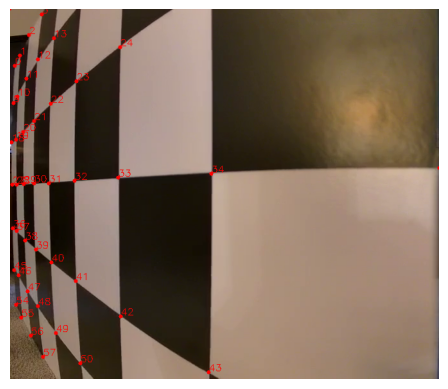

In [264]:
def add_new_corners(corners, new_corners):
    for i, point in new_corners:
        corners[i] = point
    return corners

print(left_image.shape)
new_corners = [[0, (7, 88)], [3, (49,8)],
               [35, (668, 247)],
               [45, (6, 406)],
               [54, (9, 460)], [55, (17, 480)], [56, (32, 508)]]

left_actual_corners = add_new_corners(relabeled_corners, new_corners)
displayCorners(left_image, left_actual_corners)

Create ideal corner points

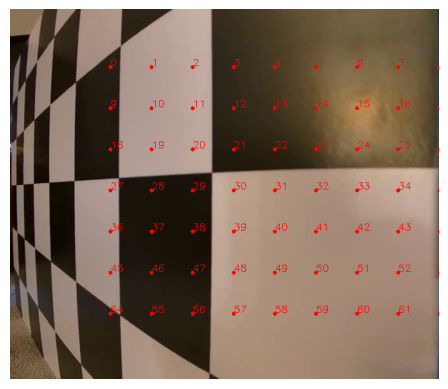

In [265]:
def create_ideal_corners(start_point, block_length, grid_size):
    ideal_corners = np.zeros((grid_size[0] * grid_size[1], 1, 2))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            ideal_corners[grid_size[1] * i + j, 0] = start_point
            start_point[0] += block_length
        start_point[1] += block_length
        start_point[0] -= block_length * grid_size[1]
    return ideal_corners

left_ideal_corners = create_ideal_corners([156, 90], 64, grid_size)
displayCorners(left_image, left_ideal_corners)

Display right camera picture of calibration board

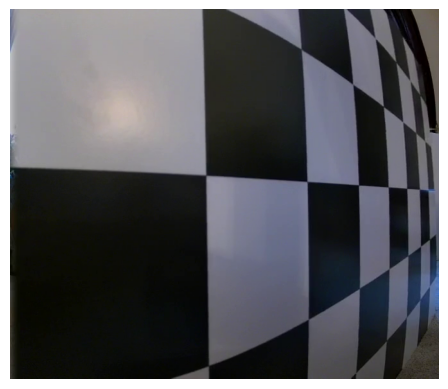

In [266]:
display(right_image)

(576, 668, 3)


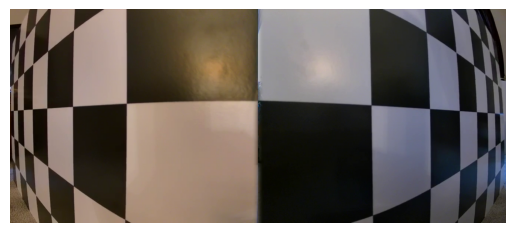

In [267]:
print(left_image.shape)
left_and_right_image = np.concatenate((left_image, right_image), axis=1)
display(left_and_right_image)

Find potential corners

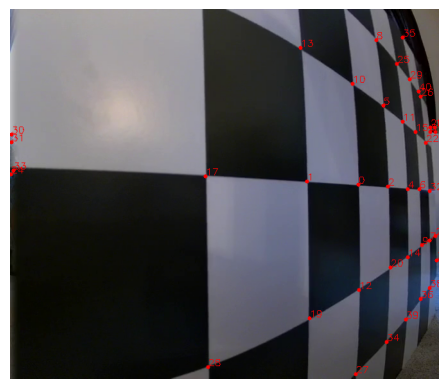

In [268]:
corners = getCorners(right_image)
displayCorners(right_image, corners)

Manually keep correct corners

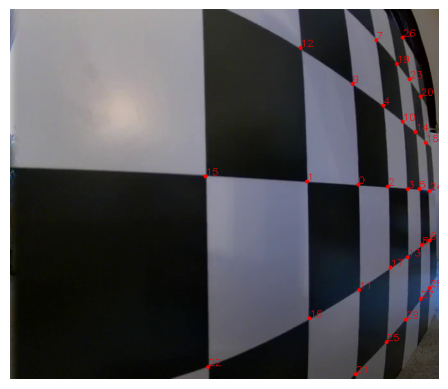

In [269]:
def keep_corners(corners, indexes_to_keep):
    mask = [False] * len(corners)
    for i in indexes_to_keep:
        mask[i] = True
    real_corners = corners[mask]
    return real_corners

indexes_to_keep = [35, 8, 25, 29, 26, 13, 10, 5, 11, 15, 22, 17, 1, 0, 2, 4, 6, 32,
                   28, 19, 12, 20, 14, 9, 7, 27, 34, 39, 36, 38]
kept_corners = keep_corners(corners, indexes_to_keep)
displayCorners(right_image, kept_corners)

Lineup the indexes of the corners

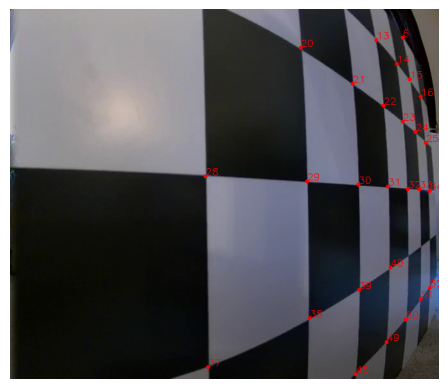

In [270]:
grid_size = (7, 9)
relabling = {26:6,
             7:13, 19:14, 23:15, 20:16,
             12:20, 9:21, 4:22, 10:23, 14:24, 18:25,
             15:28, 1:29, 0:30, 2:31, 3:32, 5:33, 24:34,
             22:37, 16:38, 11:39, 17:40, 13:40, 8:40, 6:40,
             21:48, 25:49, 29:50, 27:51, 28:52}

relabeled_corners = relabel_corner_indexes(kept_corners, relabling, grid_size)
displayCorners(right_image, relabeled_corners)

Add aditional corners

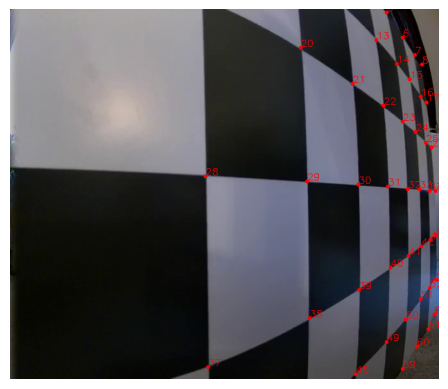

In [271]:
new_corners = [[5, (586, 5)], [7, (630, 71)], [8, (641, 86)],
               [17, (648, 145)],
               [26, (656, 215)],
               #[27, (5, 247)], 
               [35, (662, 283)],
               [41, (620, 384)], [42, (640, 369)], [43, (654, 359)], [44, (663, 351)],
               [53, (663, 421)],
               [59, (611, 560)], [60, (633, 525)], [61, (651, 498)], [62, (661, 475)]]

right_actual_corners = add_new_corners(relabeled_corners, new_corners)
displayCorners(right_image, right_actual_corners)

Create ideal corner points

(576, 668, 3)


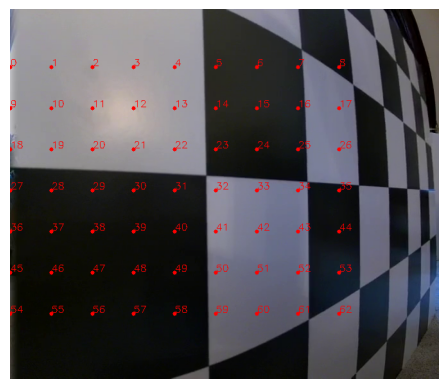

In [272]:
right_ideal_corners = create_ideal_corners([0, 90], 64, grid_size)
print(right_image.shape)
displayCorners(right_image, right_ideal_corners)

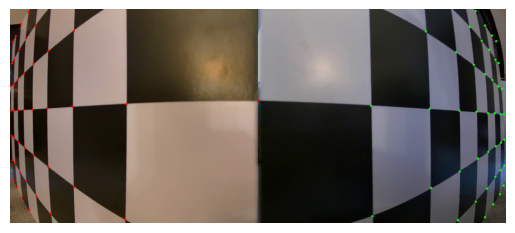

In [273]:
def displayMultipleCorners(image, corners_list, colors):
    _image = image.copy()
    for corners, color in zip(corners_list, colors):
        for i in range(len(corners)):
            point = corners[i, 0].astype(int)
            if point[1] != -1:
                cv2.circle(_image, point, 3, color, -1)
    display(_image)


corners_list = [left_actual_corners, right_actual_corners + (right_offset, 0)]
red, green = (0, 0, 255), (0, 255, 0)
colors = [red, green]
displayMultipleCorners(left_and_right_image, corners_list, colors)

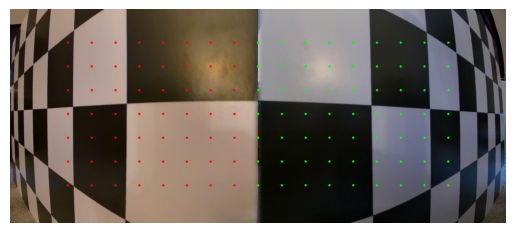

In [274]:
corners_list = [left_ideal_corners, right_ideal_corners + (right_offset, 0)]
displayMultipleCorners(left_and_right_image, corners_list, colors)

Display middle camera picture of calibration board

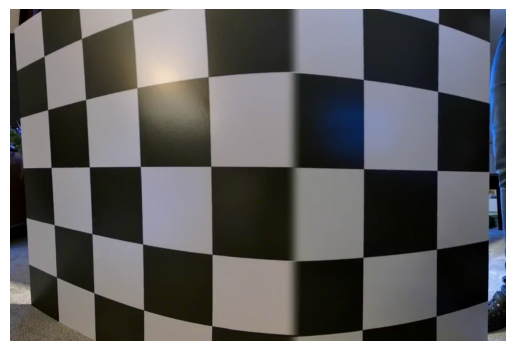

In [275]:
display(middle_image)

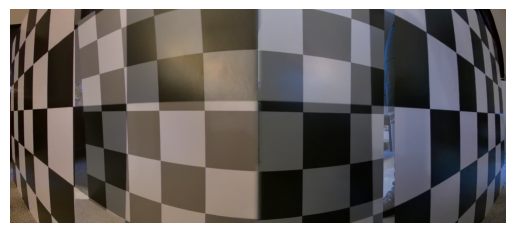

In [276]:
combined_image = left_and_right_image.copy()
combined_image[:, middle_offset_1:middle_offset_2] = cv2.addWeighted(
    left_and_right_image[:, middle_offset_1:middle_offset_2], 0.5,
    middle_image, 0.5, 0)
display(combined_image)

Find potential corners

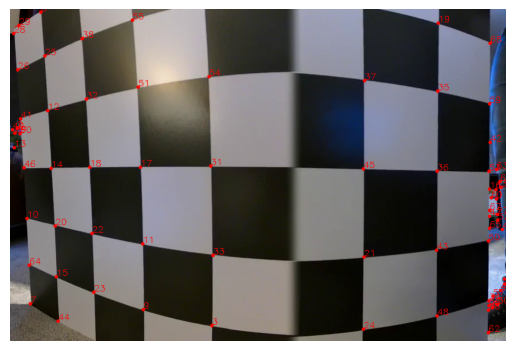

In [277]:
corners = getCorners(middle_image)
displayCorners(middle_image, corners)

Manually keep correct corners

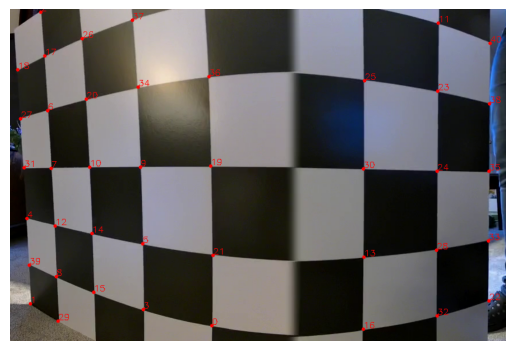

In [278]:
indexes_to_keep = [8, 26, 25, 38, 55, 19, 68, 41, 12, 32, 51, 54, 37, 35, 59, 46, 14, 18,
                   17, 31, 45, 36, 53, 10, 20, 22, 11, 33, 21, 43, 50, 64, 15, 23, 9, 3,
                   24, 48, 34, 7, 44]
kept_corners = keep_corners(corners, indexes_to_keep)
displayCorners(middle_image, kept_corners)

Lineup the indexes of the corners

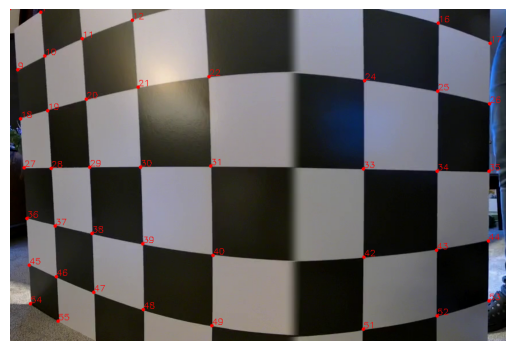

In [279]:
grid_size = (7, 9)
relabling = {2:1,
             18:9, 17:10, 26:11, 37:12, 11:16, 40:17,
             27:18, 6:19, 20:20, 34:21, 36:22, 25:24, 23:25, 38:26,
             31:27, 7:28, 10:29, 9:30, 19:31, 30:33, 24:34, 35:35,
             4:36, 12:37, 14:38, 5:39, 21:40, 13:42, 28:43, 33:44,
             39:45, 8:46, 15:47, 3:48, 0:49, 16:51, 32:52, 22:53,
             1:54, 29:55}

relabeled_corners = relabel_corner_indexes(kept_corners, relabling, grid_size)
displayCorners(middle_image, relabeled_corners)

Add additional corners

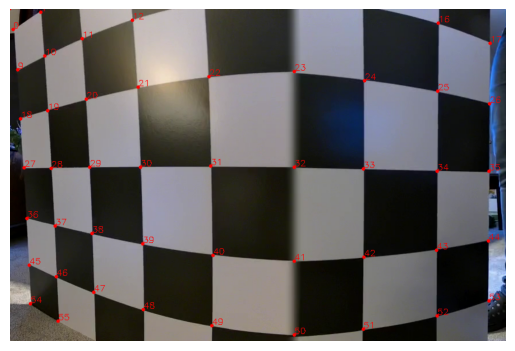

In [280]:
new_corners = [[0, (180 - middle_offset_1, 35)],
               [23, (668 - middle_offset_1, 108)],
               [32, (668 - middle_offset_1, 274)],
               [41, (668 - middle_offset_1, 437)],
               [50, (668 - middle_offset_1, 565)]]

middle_actual_corners = add_new_corners(relabeled_corners, new_corners)
displayCorners(middle_image, middle_actual_corners)

Create ideal corner points scaled to best fit the data

The values chosen were ones that seemed to calibrate it best from trial-and-error. Deriving the correct parameters is impossible from the images alone.

382
216


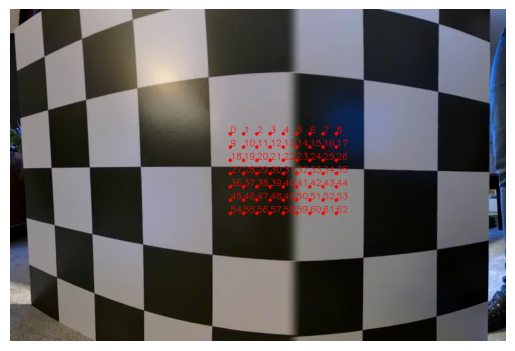

In [386]:
increment = int(64 * 1.6/5)+3
middle_ideal_corners = create_ideal_corners([382, 216], increment, grid_size)
print(right_offset - middle_offset_1 - 5 * increment+4)
print(90+3*(64-increment)+3)
displayCorners(middle_image, middle_ideal_corners)

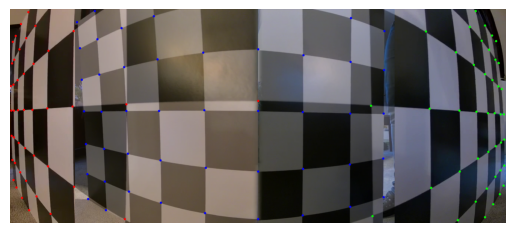

In [303]:
actual_corners_list = [left_actual_corners, right_actual_corners + (right_offset, 0),
                middle_actual_corners + (middle_offset_1, 0)]
red, green, blue = (0, 0, 255), (0, 255, 0),  (255, 0, 0)
colors = [red, green, blue]
displayMultipleCorners(combined_image, actual_corners_list, colors)

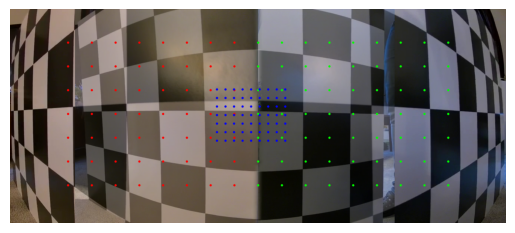

In [387]:
ideal_corners_list = [left_ideal_corners, right_ideal_corners + (right_offset, 0),
                middle_ideal_corners + (middle_offset_1, 0)]
displayMultipleCorners(combined_image, ideal_corners_list, colors)

Define Radial Basis Function

(for an in depth explanation on how RBFs work see: https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-are-radial-basis-functions-neural-networks)

In [319]:
def getRBF(actual_corners_list, ideal_corners_list, additional_points=None):
    ideal_pair = np.empty((0,2))
    actual_x = np.empty(0)
    actual_y = np.empty(0)

    for actual_corners, ideal_corners in zip(actual_corners_list, ideal_corners_list):
        print(ideal_corners.shape)
        print(actual_corners.shape)

        filter = actual_corners[:,0,1] != -1.

        ideal_pair = np.concatenate((ideal_pair, np.squeeze(ideal_corners, axis=1)[filter]))
        print(ideal_pair.dtype, ideal_pair.shape)

        actual_x = np.concatenate((actual_x, actual_corners[filter][:,0,0]))
        print(actual_x.dtype, actual_x.shape)

        actual_y = np.concatenate((actual_y, actual_corners[filter][:,0,1]))

    if additional_points is not None:
        actual_additional_points = additional_points[0]
        ideal_additional_points = additional_points[1]

        ideal_pair = np.concatenate((ideal_pair, ideal_additional_points))
        print("ideal", ideal_pair[-2:])

        actual_x = np.concatenate((actual_x, actual_additional_points[:,0]))
        print("actual x", actual_x[-2:])

        actual_y = np.concatenate((actual_y, actual_additional_points[:,1]))
        print("actual y", actual_y[-2:])

    rbf_x = RBFInterpolator(ideal_pair, actual_x)
    rbf_y = RBFInterpolator(ideal_pair, actual_y)

    return rbf_x, rbf_y, filter

In [308]:
def undistort(img, new_shape, actual_corners, ideal_corners, additional_points=None):
    old_shape = img.shape[:2]
    fun_x, fun_y, filter = getRBF(actual_corners, ideal_corners, additional_points)

    x_off = 0 #old_shape[0] - new_shape[0]
    y_off = 0 #old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return map_x, map_y, filter

(63, 1, 2)
(63, 1, 2)
float64 (43, 2)
float64 (43,)
(63, 1, 2)
(63, 1, 2)
float64 (85, 2)
float64 (85,)
(63, 1, 2)
(63, 1, 2)
float64 (131, 2)
float64 (131,)


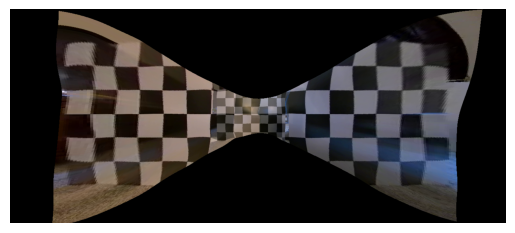

In [388]:
map_x, map_y, filter = undistort(combined_image, combined_image.shape[:2], actual_corners_list, ideal_corners_list)
mapping = np.stack((map_x, map_y), axis=2)
remapped_image = cv2.remap(combined_image, mapping, None, cv2.INTER_NEAREST)
display(remapped_image)

Save the calibration map for use in other repos

In [393]:
np.save('./calibration_npy/rbf_calibration.npy', mapping)

Verify the map was saved corectly

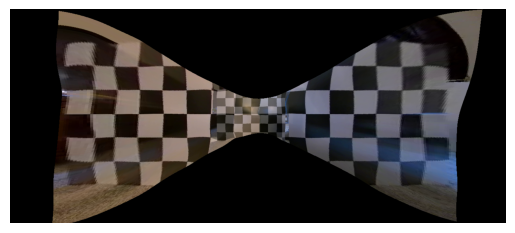

In [397]:
mapping_test = np.load('./calibration_npy/rbf_calibration.npy')
remapped_image = cv2.remap(combined_image, mapping_test, None, cv2.INTER_NEAREST)
display(remapped_image)

Display the calibrated image with the points used in training

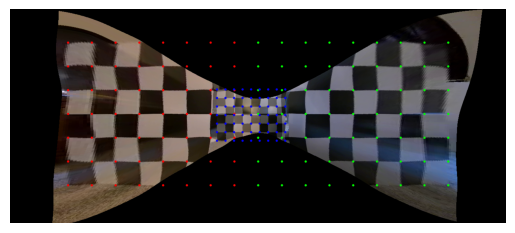

In [398]:
displayMultipleCorners(remapped_image, ideal_corners_list, colors)

Conclusion

Still looks a bit wonky but good enough for minimal viable product since locality is preserved

Further Improvents

* Sub-pixel corner detections (https://docs.opencv.org/3.4/dd/d92/tutorial_corner_subpixels.html)
* Iteratively calibrate with lidar (https://arxiv.org/pdf/2303.09825)